In [1]:
import torch
import pandas as pd
import numpy as np
import preprocessing
import utils
import matplotlib.pyplot as plt
import json

from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
from gcn import GCNModel
from torch_geometric.data import Data
from matplotlib import rcParams

In [2]:
torch.manual_seed(0)
np.random.seed(0)

profiles = pd.read_csv("../data/new_profiles_200t.csv")
comments = pd.read_csv("../data/new_comments_200t.csv")

comments = comments.drop_duplicates()
profiles = preprocessing.categorical_to_numerical(profiles, col="category_1")
all_users = set(profiles.profile_username.values)

data = preprocessing.scale(profiles.drop(columns=["category_1", "profile_username"]).values)
name_to_record = {name: record for name, record in zip(all_users, data)}

input_dim, output_dim = data.shape[1], len(profiles.category_1.unique()) + 1
user_to_label = {user: category for user, category in profiles[["profile_username", "category_1"]].values}

In [3]:
authors = profiles.profile_username.values

username_to_index = utils.get_users_indices(authors)
interactions = utils.get_interactions(comments[comments.media_author.isin(authors) & comments.commenter.isin(authors)], username_to_index)
x, y = utils.get_x(authors, name_to_record, input_dim=input_dim), utils.get_y(user_to_label, authors)

edge_index = utils.get_edge_index(interactions)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
data = Data(x=x, y=y, edge_index=edge_index).to(device)

gcn = GCNModel(x.shape[1], 64, 5, lr=0.005, n_hidden_layers=2)
history = gcn.fit(data, epochs=100)

embeddings = gcn.forward(data.x, data.edge_index, apply_activation=False)

---> (1/100) Running loss: 1.6727436780929565
---> (2/100) Running loss: 1.4913758039474487
---> (3/100) Running loss: 1.4461092948913574
---> (4/100) Running loss: 1.4279513359069824
---> (5/100) Running loss: 1.4180777072906494
---> (6/100) Running loss: 1.4114758968353271
---> (7/100) Running loss: 1.4045289754867554
---> (8/100) Running loss: 1.3952912092208862
---> (9/100) Running loss: 1.3833369016647339
---> (10/100) Running loss: 1.3694846630096436
---> (11/100) Running loss: 1.3545527458190918
---> (12/100) Running loss: 1.3393728733062744
---> (13/100) Running loss: 1.3244829177856445
---> (14/100) Running loss: 1.310180902481079
---> (15/100) Running loss: 1.296872615814209
---> (16/100) Running loss: 1.28435480594635
---> (17/100) Running loss: 1.2724469900131226
---> (18/100) Running loss: 1.2604659795761108
---> (19/100) Running loss: 1.247583031654358
---> (20/100) Running loss: 1.233641505241394
---> (21/100) Running loss: 1.2189911603927612
---> (22/100) Running loss: 

In [4]:
category1 = profiles[profiles.category_1 == 1].index.values
category2 = profiles[profiles.category_1 == 2].index.values
category3 = profiles[profiles.category_1 == 3].index.values
category4 = profiles[profiles.category_1 == 4].index.values

group_indices = [category1, category2, category3, category4]

In [5]:
def reduce_data(data, n_dim=2):
    return PCA(n_components=n_dim, random_state=0).fit_transform(data)


def plot_2d(data, group_indices):
    for group in group_indices:
        plt.scatter(data[group][:, :1], data[group][:, 1:])
    plt.show()
    

def plot_3d(data, group_indices):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    for group in group_indices:
        ax.scatter(data[group][:, :1], data[group][:, 1:2], data[group][:, 2:])
    plt.show()

In [6]:
embeddings.shape

torch.Size([1779, 64])

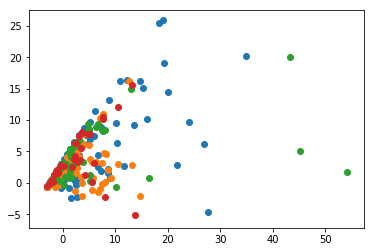

In [7]:
data = reduce_data(embeddings.detach().numpy(), n_dim=2)
plot_2d(data, group_indices)

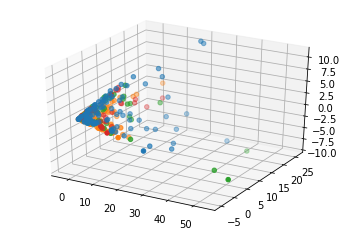

In [8]:
data = reduce_data(embeddings.detach().numpy(), n_dim=3)
plot_3d(data, group_indices)

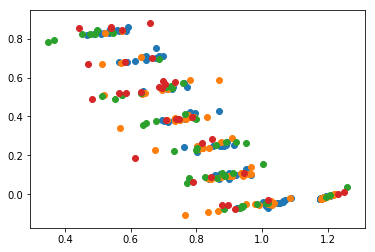

In [9]:
data = preprocessing.scale(profiles.drop(columns=["category_1", "profile_username"]).values)
data = reduce_data(data, n_dim=2)
plot_2d(data, group_indices)

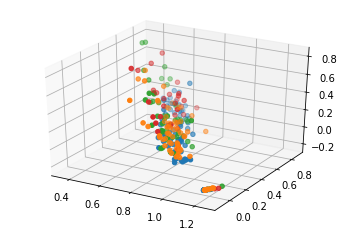

In [10]:
data = preprocessing.scale(profiles.drop(columns=["category_1", "profile_username"]).values)
data = reduce_data(data, n_dim=3)
plot_3d(data, group_indices)

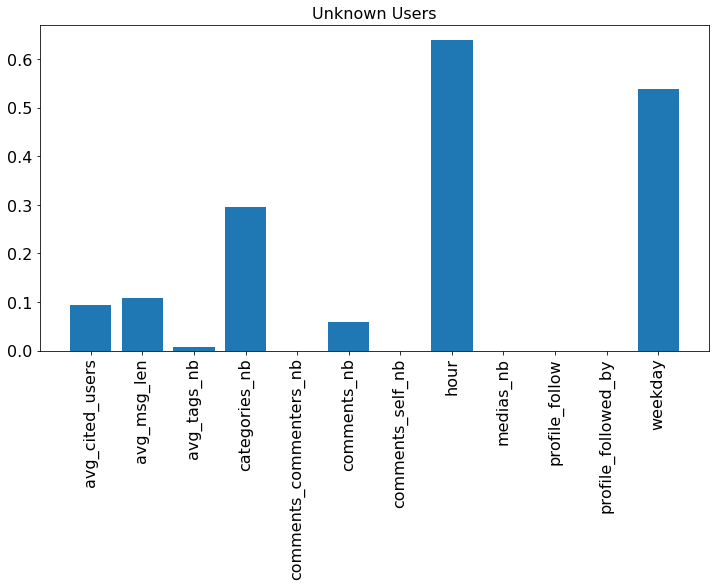

In [11]:
rcParams["figure.figsize"] = (12, 6)
category_to_numerical = {"Unknown Users": 0, "Politics": 1, "Sport": 2, "Music": 3, "Show": 4}

df_values = profiles.drop(["profile_username"], axis=1)
df_category = df_values[df_values.category_1 == category_to_numerical["Unknown Users"]]
df_category = pd.DataFrame(preprocessing.scale(df_category.values), columns=df_category.columns)\
                    .drop(["category_1", "is_tracked"], axis=1)

x = df_category.columns
y = []
for col in x:
    y.append(np.mean(df_category[col].values))

plt.bar(x, y)
plt.xticks(rotation=90, fontsize=16)
plt.yticks(fontsize=16)
plt.title("Unknown Users", fontsize=16)
plt.show()

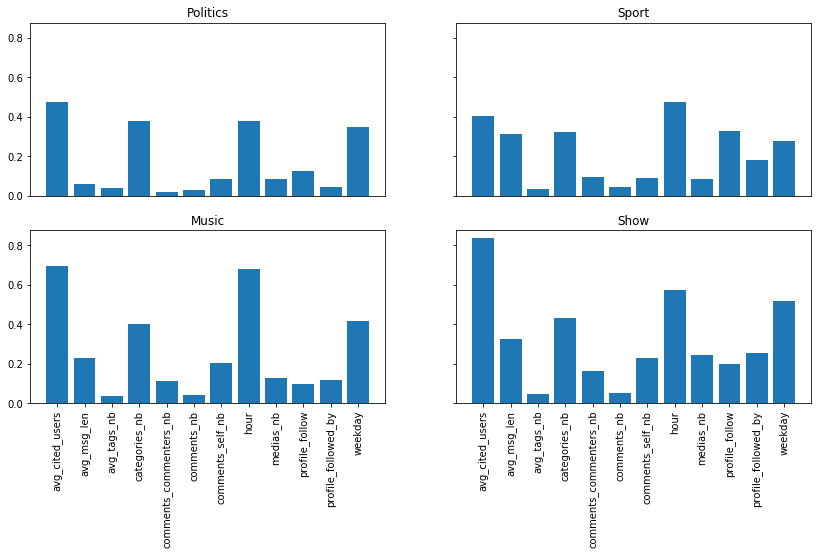

In [12]:
df_values = profiles.drop(["profile_username"], axis=1)
fig, axes = plt.subplots(2, 2, sharey=True, figsize=(14, 7))
for i, category in enumerate(["Politics", "Sport", "Music", "Show"]):    
    df_category = df_values[df_values.category_1 == category_to_numerical[category]]
    df_category = pd.DataFrame(preprocessing.scale(df_category.values), columns=df_category.columns)\
                        .drop(["category_1", "is_tracked"], axis=1)

    x = df_category.columns
    y = []
    for col in x:
        y.append(np.mean(df_category[col].values))
    
    axes[i//2, i%2].bar(x, y)
    axes[i//2, i%2].set_title(category)
    
    if i//2 != 1:
        axes[i//2, i%2].set_xticks([])
    for tick in axes[i//2, i%2].get_xticklabels():
        tick.set_rotation(90)

plt.show()

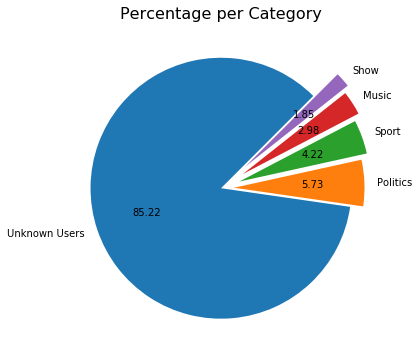

In [13]:
legends = ["Unknown Users", "Politics", "Sport", "Music", "Show"]
values = profiles[["category_1", "profile_username"]].groupby("category_1").count().values

plt.pie(values, labels=legends, autopct="%.2f", startangle=45, explode=[0, 0.1, 0.15, 0.2, 0.25])
plt.title("Percentage per Category", fontsize=16)
rcParams["font.size"] = 14
plt.show()

In [14]:
gcn_trace = json.load(open("../data/results/histories/models_histories_100e_2l_64u.json"))["GCNModel"]

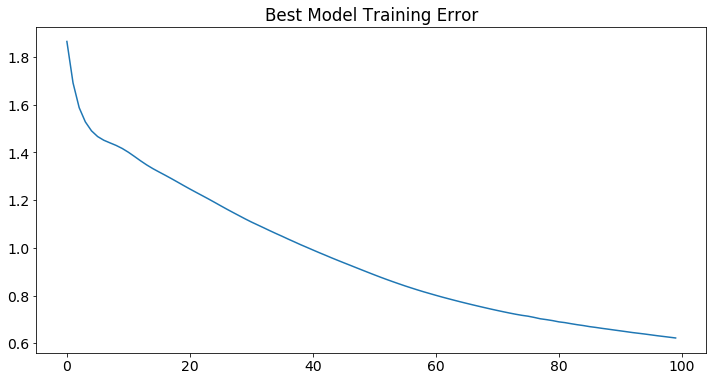

In [15]:
plt.plot(range(len(gcn_trace)), gcn_trace)
plt.title("Best Model Training Error")
plt.show()

In [16]:
y = profiles.category_1.values
x = profiles.drop(["category_1", "profile_username"], axis=1).values

In [17]:
from xgboost import XGBClassifier
from sklearn.metrics import f1_score
from sklearn.model_selection import StratifiedKFold

f1s = []
K = 5
skf = StratifiedKFold(n_splits=K)
for train_idx, test_idx in skf.split(x, y):
    xgb = XGBClassifier()
    xgb.fit(x[train_idx], y[train_idx])
    y_pred = xgb.predict(x[test_idx])
    
    f1s.append(f1_score(y[test_idx], y_pred, average="macro"))

print(np.mean(f1s), np.std(f1s))

0.696721002954871 0.036289000810455926
